<a href="https://colab.research.google.com/github/mathewsjob/Master-Thesis/blob/main/extract_features_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary packages**

In [ ]:
import os, shutil
from google.colab import drive

In [ ]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3

**Mounting Drive**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 32
img_height = 244
img_width = 244

**Setting Path**

In [ ]:
base_dir = '/content/drive/My Drive/kvasir_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
data_dir = train_dir

In [ ]:
os.listdir(data_dir)

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

**Get Categories(Class) of Dataset**

In [ ]:
def get_dataCategories(directory):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(directory, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])



directory = train_dir
categories, nbr_files = get_dataCategories(directory)

# Create DataFrame
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


categories number of files
0      dyed-lifted-polyps             700
1  dyed-resection-margins             700
2             esophagitis             700
3            normal-cecum             700
4          normal-pylorus             700
5           normal-z-line             700
6                  polyps             700
7      ulcerative-colitis             700

**Loading training dataset**

It’s good practice to use a validation split when developing your model. We will use 80% of the images for training and 20% for validation.

Validation_split float between 0 and 1. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. Shuffle the training data before each epoch.

In [130]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 5600 files belonging to 8 classes.
Using 4480 files for training.


**Loading validation dataset**

In [131]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 5600 files belonging to 8 classes.
Using 1120 files for validation.


In [132]:
train_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 5600 files belonging to 8 classes.


# Augmentation and Normalization

In [133]:
def norm_data (ds):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))
  
  return norm_ds


In [134]:
def augument_data (ds, crop_size):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = norm_ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds


In [135]:
def augument_data1 (ds, crop_size):

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds



In [136]:
train_ds_aug = augument_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)

In [137]:
val_ds_aug = augument_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)

In [138]:
train_all_aug = augument_data1 (train_all, img_height-20)
train_all_norm = norm_data (train_all_aug)

In [139]:
# performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
train_all_norm = train_all_norm.cache().prefetch(buffer_size=AUTOTUNE)


In [140]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
train_all_aug = train_all_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [141]:
class_names = train_ds.class_names
print(class_names)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


**Examples of original images:**

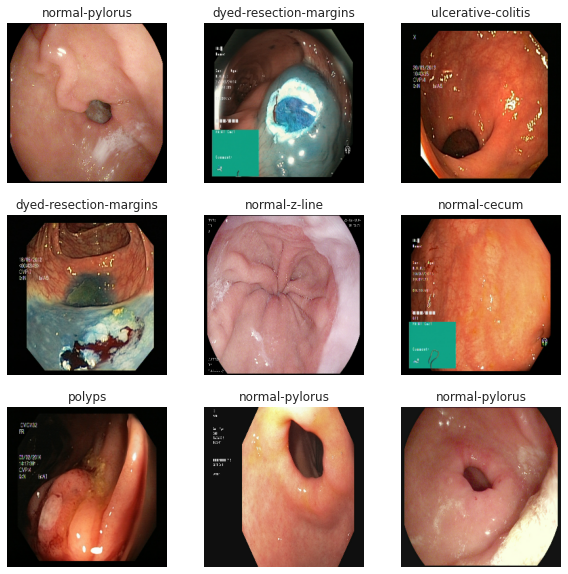

In [142]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**Examples of augmented images:**

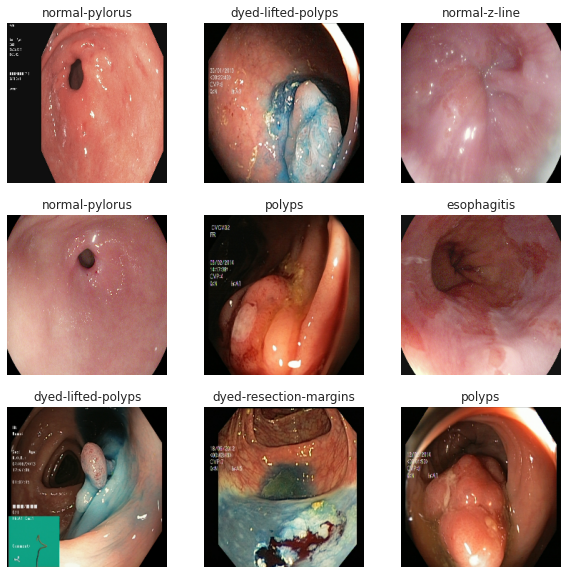

In [143]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare Test dataset

In [144]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 1600 files belonging to 8 classes.


In [145]:
test_ds_aug = augument_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

In [146]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [154]:
i = 0
y = np.zeros(shape=(1600,8))
for inputs_batch, labels_batch in test_ds_norm:
  #print(inputs_batch.shape)
  y[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= 1600:
      break

In [156]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

# CNN Model



In [157]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

num_classes = 8

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model2 = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  #layers.Dense(256, activation='relu'),
  #layers.Dropout(0.35),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

In [158]:
opt1=optimizers.RMSprop(learning_rate=2e-5)

In [159]:
opt2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

In [160]:
opt3=optimizers.RMSprop(learning_rate=0.001)

In [161]:
model2.compile(
  optimizer=opt1,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [194]:
hist_cnn_m2 = model2.fit(train_ds_norm,
  epochs=20,callbacks=[callback],
  validation_data = val_ds_norm
)

Epoch 1/20
140/140 [==============================] - 49s 353ms/step - loss: 0.7553 - accuracy: 0.7127 - val_loss: 0.5675 - val_accuracy: 0.8107
Epoch 2/20
140/140 [==============================] - 48s 344ms/step - loss: 0.7295 - accuracy: 0.7295 - val_loss: 0.5598 - val_accuracy: 0.7991
Epoch 3/20
140/140 [==============================] - 49s 347ms/step - loss: 0.7060 - accuracy: 0.7286 - val_loss: 0.5543 - val_accuracy: 0.7964
Epoch 4/20
140/140 [==============================] - 48s 346ms/step - loss: 0.6970 - accuracy: 0.7406 - val_loss: 0.5549 - val_accuracy: 0.7991
Epoch 5/20
140/140 [==============================] - 49s 347ms/step - loss: 0.6713 - accuracy: 0.7469 - val_loss: 0.5459 - val_accuracy: 0.8027
Epoch 6/20
140/140 [==============================] - 49s 347ms/step - loss: 0.6580 - accuracy: 0.7502 - val_loss: 0.5601 - val_accuracy: 0.7973
Epoch 7/20
140/140 [==============================] - 49s 347ms/step - loss: 0.6436 - accuracy: 0.7690 - val_loss: 0.5700 - val_ac

In [264]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

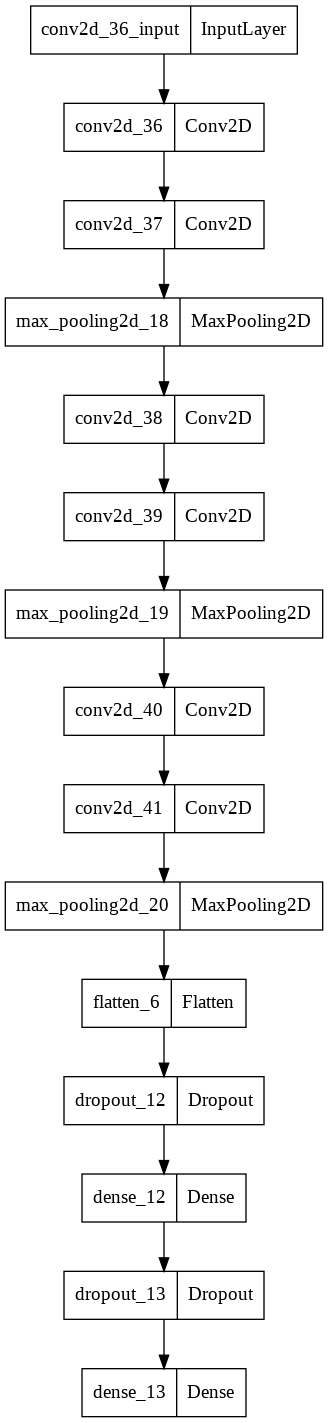

In [265]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(model2, "my_first_model.png")

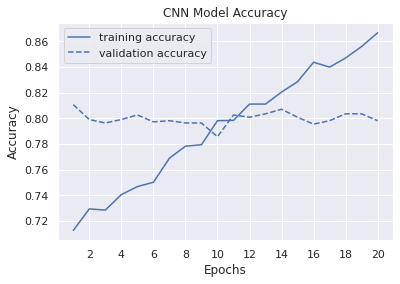

In [195]:
import matplotlib.pyplot as plt

acc = hist_cnn_m2.history['accuracy']
val_acc = hist_cnn_m2.history['val_accuracy']
loss = hist_cnn_m2.history['loss']
val_loss = hist_cnn_m2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('CNN Model Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'b--', label='validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, len(acc)+1, 2))
plt.legend()


plt.show()

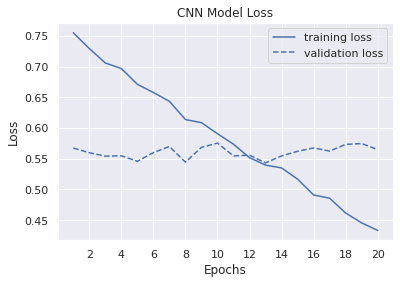

In [196]:


plt.title('CNN Model Loss')
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'b--', label='validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, len(loss)+1, 2))
plt.legend()


plt.show()

In [197]:
hist_cnn_m2 = model2.fit(val_ds_norm,
  epochs=10,
  validation_data = train_ds_norm
)

Epoch 1/10
35/35 [==============================] - 26s 758ms/step - loss: 0.6232 - accuracy: 0.7723 - val_loss: 0.4634 - val_accuracy: 0.8500
Epoch 2/10
35/35 [==============================] - 26s 759ms/step - loss: 0.5763 - accuracy: 0.7911 - val_loss: 0.4430 - val_accuracy: 0.8674
Epoch 3/10
35/35 [==============================] - 26s 759ms/step - loss: 0.5634 - accuracy: 0.8027 - val_loss: 0.4804 - val_accuracy: 0.8455
Epoch 4/10
35/35 [==============================] - 26s 760ms/step - loss: 0.5097 - accuracy: 0.8339 - val_loss: 0.4695 - val_accuracy: 0.8558
Epoch 5/10
35/35 [==============================] - 26s 760ms/step - loss: 0.4980 - accuracy: 0.8304 - val_loss: 0.4492 - val_accuracy: 0.8647
Epoch 6/10
35/35 [==============================] - 26s 759ms/step - loss: 0.4644 - accuracy: 0.8366 - val_loss: 0.4608 - val_accuracy: 0.8585
Epoch 7/10
35/35 [==============================] - 26s 760ms/step - loss: 0.4501 - accuracy: 0.8661 - val_loss: 0.5008 - val_accuracy: 0.8433

In [198]:
model2.evaluate(test_ds_norm)

50/50 [==============================] - 5s 106ms/step - loss: 0.7950 - accuracy: 0.7287


[0.7950009107589722, 0.7287499904632568]

In [199]:
test_pred = model2.predict(test_ds_norm)

50/50 [==============================] - 5s 102ms/step


In [200]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y[:], axis=1), np.argmax(test_pred[:], axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       200
           1       0.60      0.82      0.69       200
           2       0.72      0.74      0.73       200
           3       0.73      0.94      0.83       200
           4       0.93      0.97      0.95       200
           5       0.73      0.70      0.72       200
           6       0.70      0.62      0.66       200
           7       0.84      0.56      0.67       200

    accuracy                           0.73      1600
   macro avg       0.73      0.73      0.72      1600
weighted avg       0.73      0.73      0.72      1600



In [201]:
"""
   The functions uses displays the confusion matrix
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.BuPu):
    """
       display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

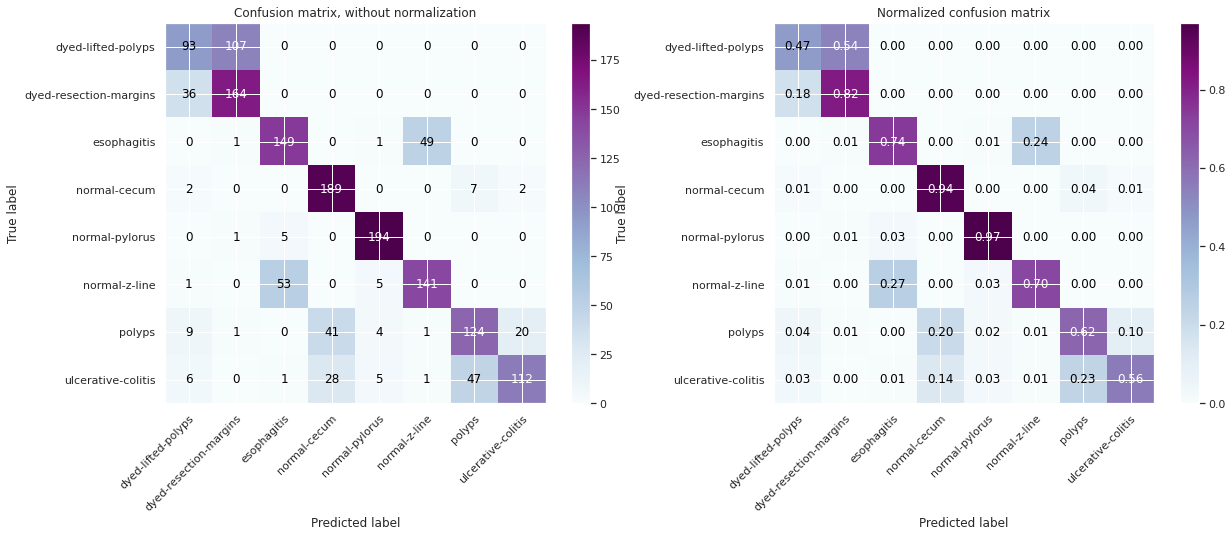

In [202]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(test_pred, axis=1))
plt_confusion_mat(cm, classes=categories, fig_size=(20, 7))

# Hyperparameters tuning



In [203]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [204]:
def get_model(num_classes = 8, drop_out=0.4, reg=None, n_densenodes=256):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=reg))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same',
                kernel_regularizer=reg))

  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out))

  model.add(layers.Dense(n_densenodes, activation='relu', kernel_regularizer=reg))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg))
  
  return model

In [205]:
def optimizer_search(iters=10):
  
  opt1 = optimizers.RMSprop(learning_rate=2e-5)
  opt2 = optimizers.RMSprop(learning_rate=2e-4)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt4 = optimizers.SGD(learning_rate=0.001, momentum=0.9)
  opt5 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
  opt6 = optimizers.SGD(learning_rate=0.01, momentum=0.9)
  opt7 = optimizers.SGD(learning_rate=0.0001, momentum=0.8)
  opt8 = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
  opt9 = optimizers.Adam()

  opt_list = [opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8, opt9]
  opt_name = ['RMSprop(learning_rate=2e-5)', 
              'RMSprop(learning_rate=2e-4)', 
              'SGD(learning_rate=0.001, momentum=0.8)',
              'SGD(learning_rate=0.001, momentum=0.9)',
              'SGD(learning_rate=0.01, momentum=0.8)',
              'SGD(learning_rate=0.01, momentum=0.9)',
              'SGD(learning_rate=0.0001, momentum=0.8)',
              'SGD(learning_rate=0.0001, momentum=0.9)',
              'adam']
  opt_hist=[]

  # regularizers.l2(1e-4)

  # 1. pick optimizer
  
  
  for i, opt in enumerate(opt_list):
    print(opt_name[i])
    model = get_model()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    opt_hist.append(h)
    print("")
  
  return opt_hist, opt_name



  """
  for m in momentums:
    model = get_model()
    opt = tf.keras.optimizers.SGD(lr=best_lr, momentum = m)
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(normtrain_ds ,epochs=iters)
    score = model.evaluate(normval_ds, verbose=0)
    if score[1] > best_acc:
      best_acc = score[1]
      best_mom = m

  print('best lr: ', best_lr)
  print('best momentum: ', best_mom)"""

  


In [206]:
opt_hist = optimizer_search()

RMSprop(learning_rate=2e-5)
Epoch 1/15
140/140 [==============================] - 49s 340ms/step - loss: 1.2440 - accuracy: 0.4801 - val_loss: 0.7667 - val_accuracy: 0.6750
Epoch 2/15
140/140 [==============================] - 46s 331ms/step - loss: 0.8626 - accuracy: 0.6138 - val_loss: 0.6776 - val_accuracy: 0.7098
Epoch 3/15
140/140 [==============================] - 47s 332ms/step - loss: 0.7854 - accuracy: 0.6391 - val_loss: 0.6467 - val_accuracy: 0.7205
Epoch 4/15
140/140 [==============================] - 46s 331ms/step - loss: 0.7280 - accuracy: 0.6725 - val_loss: 0.6183 - val_accuracy: 0.7366
Epoch 5/15
140/140 [==============================] - 46s 331ms/step - loss: 0.7069 - accuracy: 0.6873 - val_loss: 0.5912 - val_accuracy: 0.7420
Epoch 6/15
140/140 [==============================] - 46s 331ms/step - loss: 0.6774 - accuracy: 0.6967 - val_loss: 0.5815 - val_accuracy: 0.7420
Epoch 7/15
140/140 [==============================] - 46s 331ms/step - loss: 0.6455 - accuracy: 0.7217

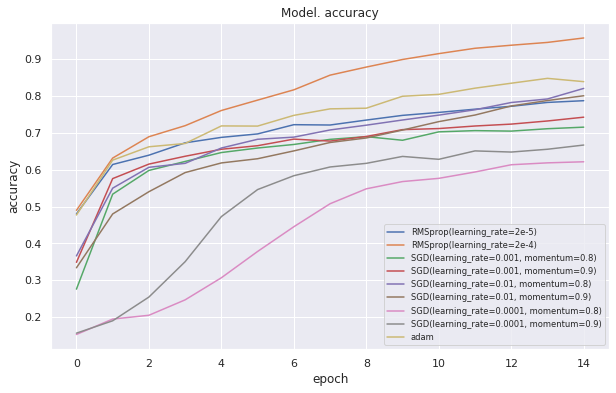

In [259]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['accuracy'])
plt.plot(opt_hist[0][1].history['accuracy'])
plt.plot(opt_hist[0][2].history['accuracy'])
plt.plot(opt_hist[0][3].history['accuracy'])
plt.plot(opt_hist[0][4].history['accuracy'])
plt.plot(opt_hist[0][5].history['accuracy'])
plt.plot(opt_hist[0][6].history['accuracy'])
plt.plot(opt_hist[0][7].history['accuracy'])
plt.plot(opt_hist[0][8].history['accuracy'])


plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


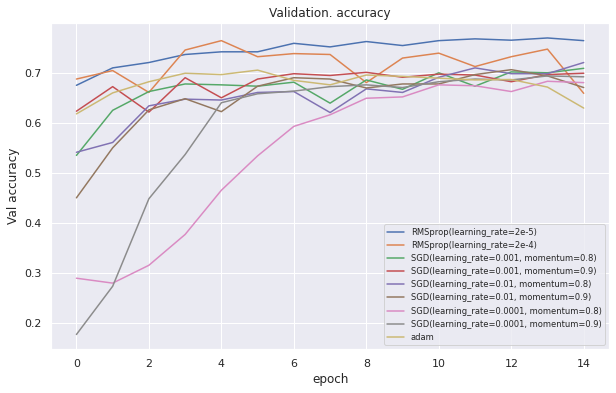

In [262]:
plt.figure(figsize=(10, 6))  

plt.plot(opt_hist[0][0].history['val_accuracy'])
plt.plot(opt_hist[0][1].history['val_accuracy'])
plt.plot(opt_hist[0][2].history['val_accuracy'])
plt.plot(opt_hist[0][3].history['val_accuracy'])
plt.plot(opt_hist[0][4].history['val_accuracy'])
plt.plot(opt_hist[0][5].history['val_accuracy'])
plt.plot(opt_hist[0][6].history['val_accuracy'])
plt.plot(opt_hist[0][7].history['val_accuracy'])
plt.plot(opt_hist[0][8].history['val_accuracy'])

plt.title('Validation. accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


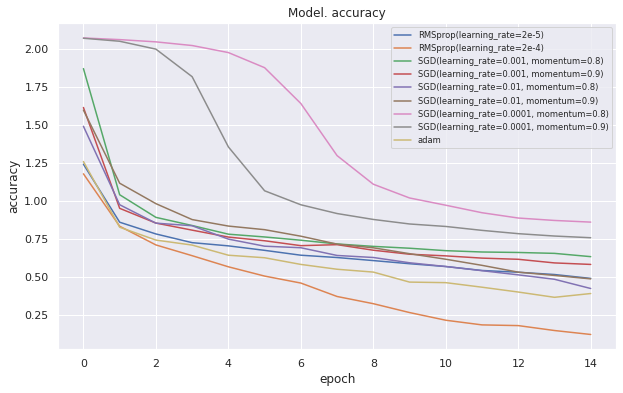

In [260]:
plt.figure(figsize=(10, 6))  


plt.plot(opt_hist[0][0].history['loss'])
plt.plot(opt_hist[0][1].history['loss'])
plt.plot(opt_hist[0][2].history['loss'])
plt.plot(opt_hist[0][3].history['loss'])
plt.plot(opt_hist[0][4].history['loss'])
plt.plot(opt_hist[0][5].history['loss'])
plt.plot(opt_hist[0][6].history['loss'])
plt.plot(opt_hist[0][7].history['loss'])
plt.plot(opt_hist[0][8].history['loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


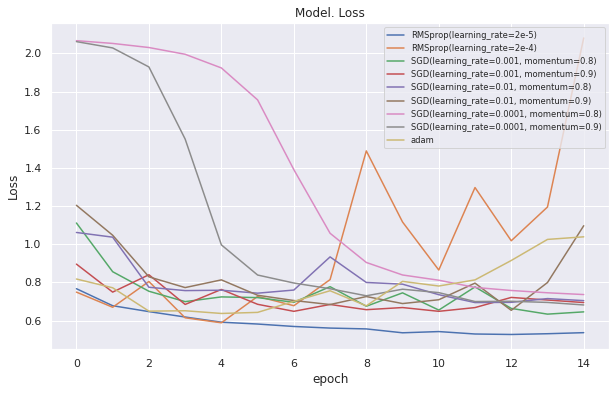

In [263]:
plt.figure(figsize=(10, 6))  



plt.plot(opt_hist[0][0].history['val_loss'])
plt.plot(opt_hist[0][1].history['val_loss'])
plt.plot(opt_hist[0][2].history['val_loss'])
plt.plot(opt_hist[0][3].history['val_loss'])
plt.plot(opt_hist[0][4].history['val_loss'])
plt.plot(opt_hist[0][5].history['val_loss'])
plt.plot(opt_hist[0][6].history['val_loss'])
plt.plot(opt_hist[0][7].history['val_loss'])
plt.plot(opt_hist[0][8].history['val_loss'])

plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([opt_hist[1][0],opt_hist[1][1],opt_hist[1][2],opt_hist[1][3],opt_hist[1][4],opt_hist[1][5],opt_hist[1][6],opt_hist[1][7],opt_hist[1][8]], loc='best', fontsize = 'x-small')  

plt.show()


In [207]:

def reguralizer_search(iters=10):
  
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  reg1 = regularizers.l2(1e-4)
  reg2 = regularizers.l1(1e-5)
  reg3 = regularizers.l2(1e-5)
  reg4 = regularizers.l2(1e-3)

  reg_list = [reg1, reg2, reg3, reg4]
  reg_name = ['regularizers.l2(1e-4)', 
              'regularizers.l1(1e-5)', 
              'regularizers.l2(1e-5)',
              'regularizers.l2(1e-3)']
  reg_hist=[]

  # regularizers.l2(1e-4)

  # 2. pick regularizer
  for i, r in enumerate(reg_list):
    print(reg_name[i])
    model = get_model(reg=r)
    model.compile(optimizer=opt3, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    reg_hist.append(h)
    print("")
  
  return reg_hist, reg_name



In [266]:
reg_hist = reguralizer_search()

regularizers.l2(1e-4)
Epoch 1/15
140/140 [==============================] - 48s 335ms/step - loss: 2.0626 - accuracy: 0.2025 - val_loss: 1.6941 - val_accuracy: 0.4911
Epoch 2/15
140/140 [==============================] - 46s 327ms/step - loss: 1.2653 - accuracy: 0.4960 - val_loss: 0.9789 - val_accuracy: 0.5902
Epoch 3/15
140/140 [==============================] - 46s 331ms/step - loss: 0.9766 - accuracy: 0.5946 - val_loss: 0.9314 - val_accuracy: 0.6080
Epoch 4/15
140/140 [==============================] - 46s 331ms/step - loss: 0.9042 - accuracy: 0.6286 - val_loss: 0.8853 - val_accuracy: 0.6187
Epoch 5/15
140/140 [==============================] - 46s 331ms/step - loss: 0.8416 - accuracy: 0.6531 - val_loss: 0.8118 - val_accuracy: 0.6536
Epoch 6/15
140/140 [==============================] - 46s 331ms/step - loss: 0.8228 - accuracy: 0.6551 - val_loss: 0.7297 - val_accuracy: 0.6777
Epoch 7/15
140/140 [==============================] - 46s 331ms/step - loss: 0.7922 - accuracy: 0.6690 - val

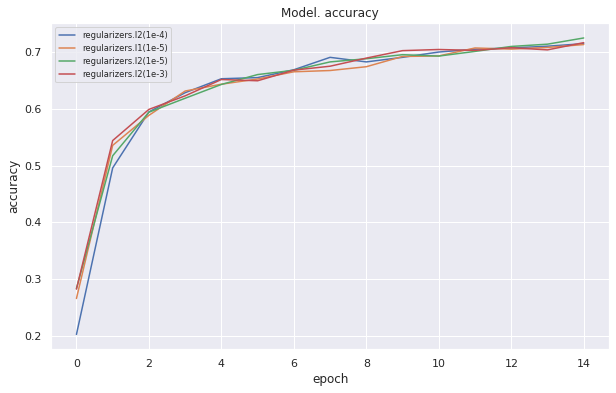

In [269]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['accuracy'])
plt.plot(reg_hist[0][1].history['accuracy'])
plt.plot(reg_hist[0][2].history['accuracy'])
plt.plot(reg_hist[0][3].history['accuracy'])



plt.title('Model. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


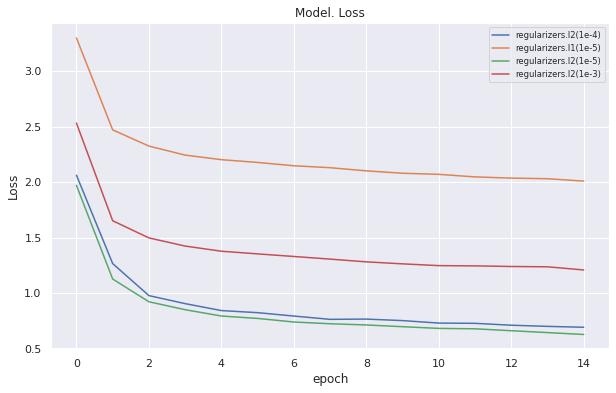

In [270]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['loss'])
plt.plot(reg_hist[0][1].history['loss'])
plt.plot(reg_hist[0][2].history['loss'])
plt.plot(reg_hist[0][3].history['loss'])



plt.title('Model. Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


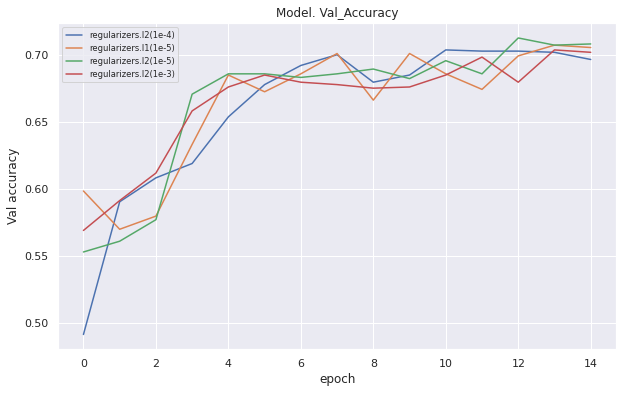

In [271]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_accuracy'])
plt.plot(reg_hist[0][1].history['val_accuracy'])
plt.plot(reg_hist[0][2].history['val_accuracy'])
plt.plot(reg_hist[0][3].history['val_accuracy'])



plt.title('Model. Val_Accuracy')  
plt.ylabel('Val accuracy')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


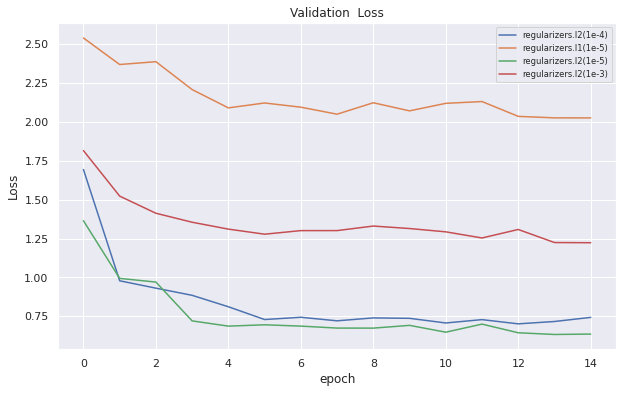

In [272]:
plt.figure(figsize=(10, 6))  



plt.plot(reg_hist[0][0].history['val_loss'])
plt.plot(reg_hist[0][1].history['val_loss'])
plt.plot(reg_hist[0][2].history['val_loss'])
plt.plot(reg_hist[0][3].history['val_loss'])



plt.title('Validation  Loss')  
plt.ylabel('Loss')  
plt.xlabel('epoch')  
plt.legend([reg_hist[1][0],reg_hist[1][1],reg_hist[1][2],reg_hist[1][3]], loc='best', fontsize = 'x-small')  

plt.show()


# Learn and extract image features

## VGG16

In [273]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [274]:


# load model without classifier layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [275]:
opt1 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(learning_rate=2e-5)
opt3="adam"

In [276]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [277]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
140/140 [==============================] - 73s 503ms/step - loss: 1.3034 - accuracy: 0.5054 - val_loss: 0.6860 - val_accuracy: 0.7214
Epoch 2/20
140/140 [==============================] - 70s 498ms/step - loss: 0.6942 - accuracy: 0.7304 - val_loss: 0.6412 - val_accuracy: 0.7634
Epoch 3/20
140/140 [==============================] - 69s 497ms/step - loss: 0.5160 - accuracy: 0.8136 - val_loss: 0.5065 - val_accuracy: 0.8214
Epoch 4/20
140/140 [==============================] - 70s 500ms/step - loss: 0.3910 - accuracy: 0.8607 - val_loss: 0.4171 - val_accuracy: 0.8625
Epoch 5/20
140/140 [==============================] - 70s 500ms/step - loss: 0.3249 - accuracy: 0.8839 - val_loss: 0.4652 - val_accuracy: 0.8420
Epoch 6/20
140/140 [==============================] - 70s 498ms/step - loss: 0.2816 - accuracy: 0.9089 - val_loss: 0.3977 - val_accuracy: 0.8777
Epoch 7/20
140/140 [==============================] - 70s 497ms/step - loss: 0.2366 - accuracy: 0.9246 - val_loss: 0.4427 - val_ac

In [278]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
175/175 [==============================] - 82s 460ms/step - loss: 0.1472 - accuracy: 0.9643
Epoch 2/14
175/175 [==============================] - 81s 460ms/step - loss: 0.1325 - accuracy: 0.9668
Epoch 3/14
175/175 [==============================] - 81s 460ms/step - loss: 0.0944 - accuracy: 0.9782
Epoch 4/14
175/175 [==============================] - 80s 457ms/step - loss: 0.0833 - accuracy: 0.9804
Epoch 5/14
175/175 [==============================] - 80s 459ms/step - loss: 0.0857 - accuracy: 0.9825
Epoch 6/14
175/175 [==============================] - 80s 458ms/step - loss: 0.0731 - accuracy: 0.9877
Epoch 7/14
175/175 [==============================] - 80s 459ms/step - loss: 0.0647 - accuracy: 0.9887
Epoch 8/14
175/175 [==============================] - 80s 459ms/step - loss: 0.0717 - accuracy: 0.9877
Epoch 9/14
175/175 [==============================] - 80s 459ms/step - loss: 0.0594 - accuracy: 0.9896
Epoch 10/14
175/175 [==============================] - 80s 459ms/step - l

In [279]:
model.save("vgg16.h5")

In [280]:
from keras.models import load_model

In [281]:
model_vgg = load_model('vgg16.h5')

In [282]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [283]:
vgg_features_model = Model (model_vgg.layers[0].input,  model_vgg.layers[21].output)

In [284]:
vgg_features_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

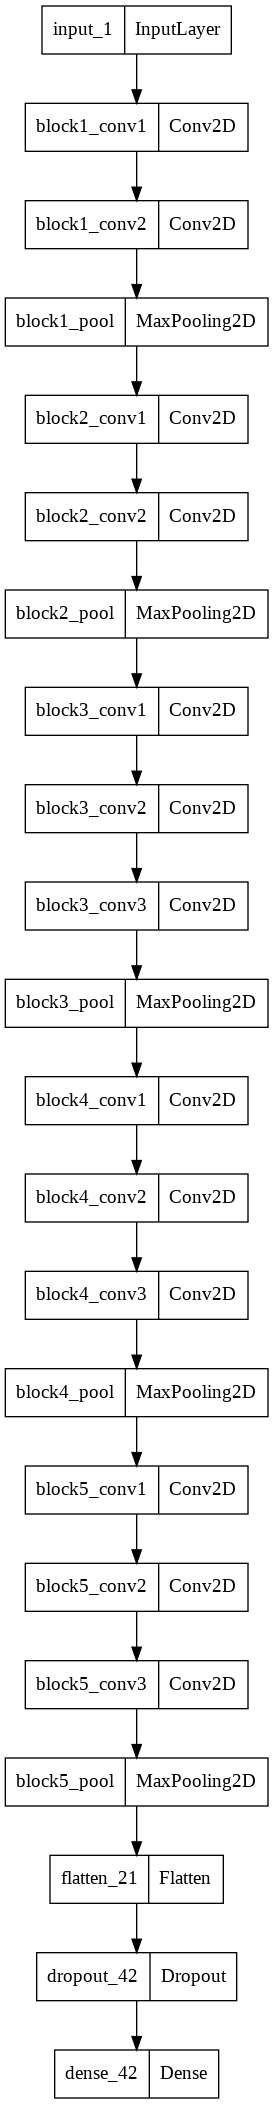

In [329]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(vgg_features_model, "vgg.png")

In [285]:
model_vgg.evaluate(test_ds_norm)

50/50 [==============================] - 8s 163ms/step - loss: 0.4695 - accuracy: 0.8931


[0.4694967567920685, 0.8931249976158142]

In [286]:
predict_test = model_vgg.predict(test_ds_norm)

50/50 [==============================] - 8s 163ms/step


In [287]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(predict_test, axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       200
           1       0.90      0.94      0.92       200
           2       0.77      0.80      0.78       200
           3       0.95      0.99      0.97       200
           4       0.95      1.00      0.97       200
           5       0.80      0.76      0.78       200
           6       0.99      0.80      0.89       200
           7       0.90      0.95      0.93       200

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600



In [288]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average='weighted')

0.8948559719202723

In [289]:
np.average(recall_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.893125

In [290]:
np.average(f1_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.8923216133678696

In [291]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))


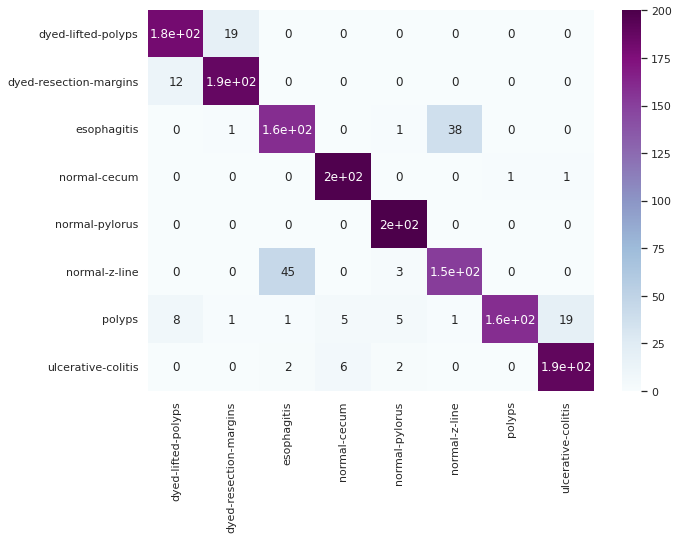

In [309]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

In [328]:
df_cm

dyed-lifted-polyps  dyed-resection-margins  \
dyed-lifted-polyps                     185                      11   
dyed-resection-margins                  16                     183   
esophagitis                              0                       0   
normal-cecum                             0                       0   
normal-pylorus                           0                       0   
normal-z-line                            0                       0   
polyps                                   1                       0   
ulcerative-colitis                       0                       0   

                        esophagitis  normal-cecum  normal-pylorus  \
dyed-lifted-polyps                0             0               0   
dyed-resection-margins            0             0               0   
esophagitis                     176             0               0   
normal-cecum                      0           197               0   
normal-pylorus                    0             0             200   
normal-z-line                    17             0               0   
polyps                            0             4               4   
ulcerative-colitis                2             4               1   

                        normal-z-line  polyps  ulcerative-colitis  
dyed-lifted-polyps                  0       4                   0  
dyed-resection-margins              0       1                   0  
esophagitis                        23       1                   0  
normal-cecum                        0       2                   1  
normal-pylorus                      0       0                   0  
normal-z-line                     183       0                   0  
polyps                              0     190                   1  
ulcerative-colitis                  0       3                 190

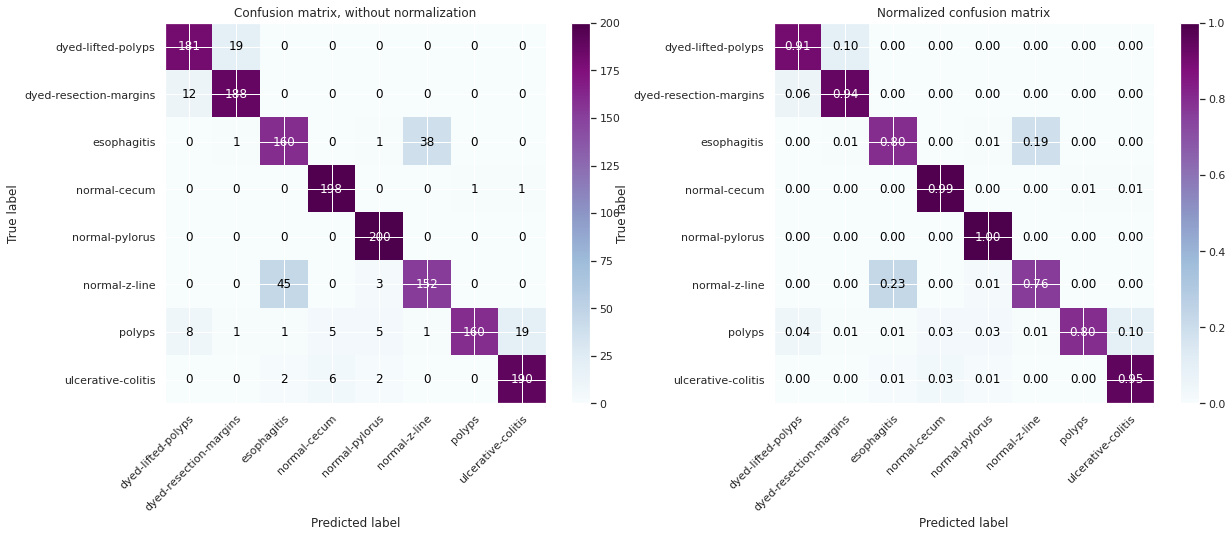

In [295]:
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
plt_confusion_mat(cm, classes=class_names, fig_size=(20, 7))

## DenseNet-169

In [310]:
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers

# load model without classifier layers
model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.5)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)

# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

51877672/51877672 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.561434 to fit



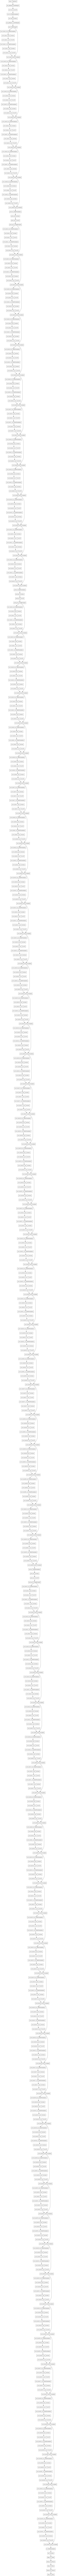

In [330]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(model, "vgg.png")

In [311]:
model.compile(
  optimizer=optimizers.RMSprop(learning_rate=2e-5),
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [312]:
history3 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
140/140 [==============================] - 105s 510ms/step - loss: 1.5443 - accuracy: 0.5067 - val_loss: 0.5789 - val_accuracy: 0.7830
Epoch 2/20
140/140 [==============================] - 69s 493ms/step - loss: 0.6188 - accuracy: 0.7821 - val_loss: 0.4252 - val_accuracy: 0.8554
Epoch 3/20
140/140 [==============================] - 69s 492ms/step - loss: 0.3963 - accuracy: 0.8703 - val_loss: 0.3508 - val_accuracy: 0.8813
Epoch 4/20
140/140 [==============================] - 69s 492ms/step - loss: 0.2491 - accuracy: 0.9246 - val_loss: 0.4342 - val_accuracy: 0.8839
Epoch 5/20
140/140 [==============================] - 69s 492ms/step - loss: 0.1731 - accuracy: 0.9473 - val_loss: 0.4550 - val_accuracy: 0.8911
Epoch 6/20
140/140 [==============================] - 69s 493ms/step - loss: 0.1142 - accuracy: 0.9705 - val_loss: 0.5361 - val_accuracy: 0.8946
Epoch 7/20
140/140 [==============================] - 69s 493ms/step - loss: 0.0912 - accuracy: 0.9770 - val_loss: 0.6353 - val_a

In [313]:
model.fit(train_all_norm,
          epochs=17)

Epoch 1/17
175/175 [==============================] - 81s 464ms/step - loss: 0.2510 - accuracy: 0.9625
Epoch 2/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0739 - accuracy: 0.9832
Epoch 3/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0373 - accuracy: 0.9936
Epoch 4/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0379 - accuracy: 0.9934
Epoch 5/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0259 - accuracy: 0.9964
Epoch 6/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0267 - accuracy: 0.9968
Epoch 7/17
175/175 [==============================] - 81s 464ms/step - loss: 0.0190 - accuracy: 0.9979
Epoch 8/17
175/175 [==============================] - 81s 463ms/step - loss: 0.0154 - accuracy: 0.9995
Epoch 9/17
175/175 [==============================] - 81s 463ms/step - loss: 0.0139 - accuracy: 0.9987
Epoch 10/17
175/175 [==============================] - 81s 463ms/step - l

In [314]:
model.evaluate(test_ds_norm)

50/50 [==============================] - 6s 118ms/step - loss: 0.6671 - accuracy: 0.9400


[0.6671034097671509, 0.9399999976158142]

In [315]:
predict_test = model.predict(test_ds_norm)

50/50 [==============================] - 8s 112ms/step


In [316]:
predict_test.shape

(1600, 8)

In [317]:
model.save("densenet.h5")

In [318]:
from keras.models import load_model
model_dn = load_model('densenet.h5')

In [319]:
model_dn.summary ()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [320]:
dn_features_model = Model (model_dn.layers[0].input,  model_dn.layers[597].output)

In [321]:
dn_features_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [322]:
pred_test = model.predict(test_ds_norm)

50/50 [==============================] - 6s 112ms/step


In [323]:
from sklearn.metrics import precision_score, recall_score, f1_score
np.average(precision_score(np.argmax(y, axis=1), np.argmax(pred_test, axis=1), average='weighted'))

0.9401870626731973

In [324]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(pred_test, axis=1))

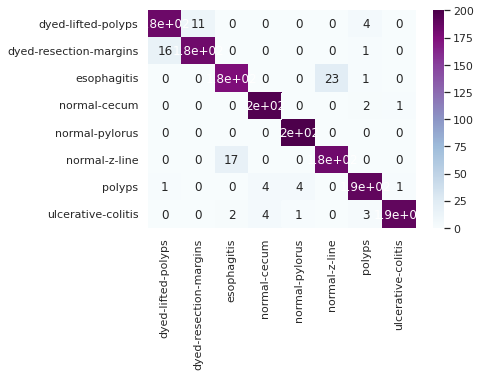

In [325]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

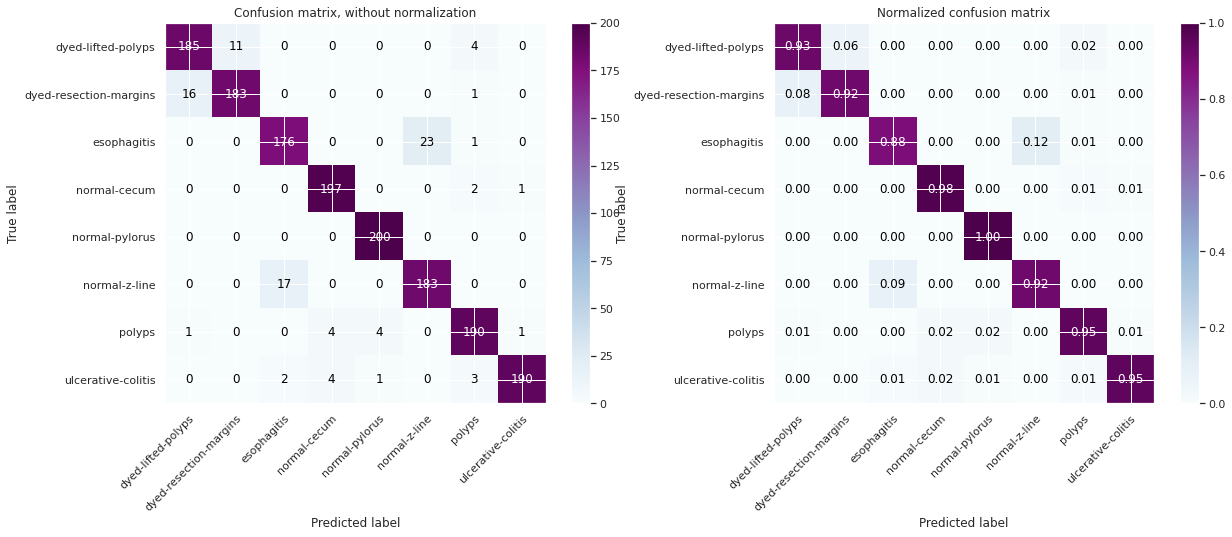

In [326]:
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(pred_test, axis=1))
plt_confusion_mat(cm, classes=class_names, fig_size=(20, 7))

In [327]:
df_cm

dyed-lifted-polyps  dyed-resection-margins  \
dyed-lifted-polyps                     185                      11   
dyed-resection-margins                  16                     183   
esophagitis                              0                       0   
normal-cecum                             0                       0   
normal-pylorus                           0                       0   
normal-z-line                            0                       0   
polyps                                   1                       0   
ulcerative-colitis                       0                       0   

                        esophagitis  normal-cecum  normal-pylorus  \
dyed-lifted-polyps                0             0               0   
dyed-resection-margins            0             0               0   
esophagitis                     176             0               0   
normal-cecum                      0           197               0   
normal-pylorus                    0             0             200   
normal-z-line                    17             0               0   
polyps                            0             4               4   
ulcerative-colitis                2             4               1   

                        normal-z-line  polyps  ulcerative-colitis  
dyed-lifted-polyps                  0       4                   0  
dyed-resection-margins              0       1                   0  
esophagitis                        23       1                   0  
normal-cecum                        0       2                   1  
normal-pylorus                      0       0                   0  
normal-z-line                     183       0                   0  
polyps                              0     190                   1  
ulcerative-colitis                  0       3                 190

# Save features to pickle file for future use

In [ ]:
import pandas as pd

In [ ]:
vgg_features = vgg_features_model.predict(train_ds_norm)
vgg_features_val = vgg_features_model.predict(val_ds_norm)
vgg_features_test = vgg_features_model.predict(test_ds_norm)

In [ ]:
df_features = pd.DataFrame(vgg_features)
df_features.to_pickle("vgg_features.pkl")
df_features = pd.DataFrame(vgg_features_val)
df_features.to_pickle("vgg_features_val.pkl")
df_features = pd.DataFrame(vgg_features_test)
df_features.to_pickle("vgg_features_test.pkl")

In [ ]:
dn_features = dn_features_model.predict(train_ds_norm)
dn_features_val = dn_features_model.predict(val_ds_norm)
dn_features_test = dn_features_model.predict(test_ds_norm)

In [ ]:
y_train = np.concatenate([y for x, y in train_ds_norm], axis=0)
y_val = np.concatenate([y for x, y in val_ds_norm], axis=0)
y_test = np.concatenate([y for x, y in test_ds_norm], axis=0)

In [ ]:
df_features = pd.DataFrame(dn_features)
df_features["label"] = np.argmax(y_train, axis=1)
df_features.to_pickle("dn_features.pkl")

df_features = pd.DataFrame(dn_features_val)
df_features["label"] = np.argmax(y_val, axis=1)
df_features.to_pickle("dn_features_val.pkl")

df_features = pd.DataFrame(dn_features_test)
df_features["label"] = np.argmax(y_test, axis=1)
df_features.to_pickle("dn_features_test.pkl")

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
vgg_features = np.array(pd.read_pickle("vgg_features.pkl"))
dn_features = np.array(pd.read_pickle("dn_features.pkl"))
vgg_features_val = np.array(pd.read_pickle("vgg_features_val.pkl"))
dn_features_val = np.array(pd.read_pickle("dn_features_val.pkl"))
vgg_features_test = np.array(pd.read_pickle("vgg_features_test.pkl"))
dn_features_test = np.array(pd.read_pickle("dn_features_test.pkl"))

In [ ]:
# extract class labels
y_train = dn_features[:,-1]
y_val = dn_features_val[:,-1]
y_test = dn_features_test[:,-1]

In [ ]:
dn_features_val = dn_features_val[:,:-1]
dn_features = dn_features[:,:-1]
dn_features_test = dn_features_test[:,:-1]

In [ ]:
combined_features = np.concatenate ((dn_features, vgg_features), axis=1)
combined_features_val = np.concatenate ((dn_features_val, vgg_features_val), axis=1)
combined_features_test = np.concatenate ((dn_features_test, vgg_features_test), axis=1)

In [ ]:
# 256 features from VGG16 + 256 features from DenseNet169
print ("combined_features.shape: ", combined_features.shape)
print ("combined_features_val.shape: ", combined_features_val.shape)
print ("combined_features_test.shape: ", combined_features_test.shape)

In [ ]:
import time
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(combined_features.shape[1]) ]
df = pd.DataFrame(combined_features,columns=feat_cols)
df['class'] = y_train
df['label'] = df['class'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
lr = LogisticRegression(max_iter=10000)

In [ ]:
combined_features_all = np.concatenate((combined_features, combined_features_val))
y_train_all = np.concatenate((y_train, y_val))

In [ ]:
combined_features_all.shape

In [ ]:
y_train_all.shape

In [ ]:
lr.fit(combined_features, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# training set accuracy
y_pred = lr.predict(combined_features_test)
accuracy_score( y_test, y_pred)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
precision_score(y_test, y_pred, average="weighted")

In [ ]:
recall_score(y_test, y_pred, average="weighted")

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="BuPu") # font size

plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier()
mlp.fit(combined_features, y_train)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(combined_features, y_train)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(combined_features, y_train)

In [ ]:
pred_test1 = neigh.predict(combined_features_test)

In [ ]:
pred_test2 = dt.predict(combined_features_test)

In [ ]:
pred_test3 = mlp.predict(combined_features_test)

In [ ]:
accuracy_score(y_test, pred_test1) # KNeighborsClassifier accuracy

In [ ]:
accuracy_score(y_test, pred_test2) # DecisionTreeClassifier accuracy

In [ ]:
accuracy_score(y_test, pred_test3) # MLP classifier accuracy